### Import all the packages

In [1]:
from build_user_subreddit_history import read_json_list
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from community import community_louvain
import matplotlib.cm as cm
from datetime import datetime
from datetime import date
import datetime as dt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import spacy
spacy.prefer_gpu()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from gensim.models import TfidfModel

# LDA Topic modeling
import json
import glob
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#nltk
import nltk
from nltk.corpus import stopwords
#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Trend and correlation between Covid-19 new cases and sentiment of posts

In [2]:
# Select variables that I want related to the posts: time, text, date
def get_contents(sub):
    
    result_dic = {}
    
    filename = "new_data/{1}/{0}/{1}_jsonlists.gz".format(sub, 'posts')
    
    i = 0
    
    for dic in read_json_list(filename):
            result = {}
            if 'selftext' in dic:
                title = dic['title']
                text = dic['selftext']
                subreddit = dic['subreddit']
                created_time = dic['created_utc']   
                if text != '[removed]'and text !='[deleted]':
                    result['text'] = title+' '+text 
                    result['time'] = datetime.utcfromtimestamp(created_time).strftime('%Y-%m-%d %H:%M:%S')
                    result['date'] = result['time'][:10]
                    result_dic[i] = result
                    i += 1
    print(i)
    return result_dic

In [3]:
workfromhome = get_contents('WorkFromHome')

6180


In [4]:
def sentiment_scores(sentence):
    
    result = 0
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.35 :
        result = "Positive"
 
    elif sentiment_dict['compound'] <= - 0.05 :
        result = "Negative"
 
    else :
        result = "Neutral"

    return result

In [5]:
positive,negative,neutral,num = 0,0,0,0
for k,v in workfromhome.items():
    workfromhome[k]["sentiment"] = sentiment_scores(v['text'])
    result = workfromhome[k]["sentiment"]
    num += 1
    if result == "Positive":
        positive += 1
    elif result == "Negative":
        negative += 1
    else:
        neutral += 1

In [6]:
first_wave = ['2020-10','2020-11','2020-12','2021-01']
second_wave = ['2021-03','2021-04','2021-05']
fourth_wave = ['2021-12','2022-01','2022-02','2022-03','2022-04']

In [7]:
first_wave_text = []
second_wave_text = []
fourth_wave_text = []
for k,v in workfromhome.items():
    if v['date'][:7] in first_wave and v["sentiment"] == "Positive":
        first_wave_text.append(v['text'])
    elif v['date'][:7] in second_wave and v["sentiment"] == "Positive":
        second_wave_text.append(v['text'])
    elif v['date'][:7] in fourth_wave and v["sentiment"] == "Positive":
        fourth_wave_text.append(v['text'])

In [8]:
begin_text = []
for k,v in workfromhome.items():
    if v['date'][:7] == '2020-03' and v["sentiment"] == "Positive":
        begin_text.append(v['text'])

In [9]:
len(first_wave_text)

595

In [10]:
len(second_wave_text)

344

In [11]:
len(fourth_wave_text)

778

In [12]:
len(begin_text)

108

In [13]:
print(positive/num, negative/num, neutral/num)

0.5718446601941748 0.13737864077669903 0.29077669902912623


In [14]:
# 2020/2021/2022
positive,negative,neutral,num = 0,0,0,0
for k,v in workfromhome.items():
    if v['date'][:4] =='2020':
        result = workfromhome[k]["sentiment"]
        num += 1
        if result == "Positive":
            positive += 1
        elif result == "Negative":
            negative += 1
        else:
            neutral += 1
    

In [15]:
# 2020
print(positive/num,negative/num,neutral/num) 

0.5623836126629422 0.11033519553072625 0.3272811918063315


In [16]:
year_month = ['2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12','2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04']

In [17]:
dic = {}
for i in year_month:
    dic[i] = {}
    dic[i]['positive'] = 0
    dic[i]['negative'] = 0
    dic[i]['neutral'] = 0
    dic[i]['num'] = 0  
    for k,v in workfromhome.items():
        if v['date'][:7] == i:
            dic[i]["num"] += 1
            result = workfromhome[k]["sentiment"]
            if result == "Positive":
                dic[i]['positive'] += 1
            elif result == "Negative":
                dic[i]['negative'] += 1
            else:
                 dic[i]['neutral'] += 1
    

In [18]:
for k,v in dic.items():
    dic[k]["positive_rate"] = v['positive']/v['num']
    dic[k]["negative_rate"] = v['negative']/v['num']
    dic[k]["neutral_rate"] = v['neutral']/v['num']

In [19]:
dic

{'2020-03': {'positive': 108,
  'negative': 21,
  'neutral': 52,
  'num': 181,
  'positive_rate': 0.5966850828729282,
  'negative_rate': 0.11602209944751381,
  'neutral_rate': 0.287292817679558},
 '2020-04': {'positive': 172,
  'negative': 36,
  'neutral': 126,
  'num': 334,
  'positive_rate': 0.5149700598802395,
  'negative_rate': 0.10778443113772455,
  'neutral_rate': 0.3772455089820359},
 '2020-05': {'positive': 127,
  'negative': 31,
  'neutral': 87,
  'num': 245,
  'positive_rate': 0.5183673469387755,
  'negative_rate': 0.12653061224489795,
  'neutral_rate': 0.3551020408163265},
 '2020-06': {'positive': 105,
  'negative': 23,
  'neutral': 69,
  'num': 197,
  'positive_rate': 0.5329949238578681,
  'negative_rate': 0.116751269035533,
  'neutral_rate': 0.350253807106599},
 '2020-07': {'positive': 93,
  'negative': 13,
  'neutral': 66,
  'num': 172,
  'positive_rate': 0.5406976744186046,
  'negative_rate': 0.0755813953488372,
  'neutral_rate': 0.38372093023255816},
 '2020-08': {'posit

In [20]:
values_num = [list(dic.values())[i]['num'] for i in range(len(dic.keys()))]
values_positiverate = [list(dic.values())[i]['positive_rate'] for i in range(len(dic.keys()))]
values_negativerate= [list(dic.values())[i]['negative_rate'] for i in range(len(dic.keys()))]
values_neutralrate = [list(dic.values())[i]['neutral_rate'] for i in range(len(dic.keys()))]
df = pd.DataFrame(year_month, columns = ['Time'])
df['Posts(num)'] = values_num
df['posts positive rate'] = values_positiverate
df['posts negative rate'] = values_negativerate
df['posts neutral rate'] = values_neutralrate

In [21]:
df

,Time,Posts(num),posts positive rate,posts negative rate,posts neutral rate
0,2020-03,181,0.596685,0.116022,0.287293
1,2020-04,334,0.514970,0.107784,0.377246
2,2020-05,245,0.518367,0.126531,0.355102
3,2020-06,197,0.532995,0.116751,0.350254
4,2020-07,172,0.540698,0.075581,0.383721
5,2020-08,188,0.531915,0.127660,0.340426
6,2020-09,184,0.565217,0.119565,0.315217
7,2020-10,207,0.618357,0.072464,0.309179
8,2020-11,212,0.636792,0.136792,0.226415
9,2020-12,228,0.596491,0.100877,0.302632


In [22]:
covid_cases = pd.read_csv('Covid-19 new cases.csv')  

In [23]:
df['US covid-19 New Cases'] = covid_cases['US New Cases']
df['Global covid-19 New Cases'] = covid_cases['Global New Cases']

In [24]:
df

,Time,Posts(num),posts positive rate,posts negative rate,posts neutral rate,US covid-19 New Cases,Global covid-19 New Cases
0,2020-03,181,0.596685,0.116022,0.287293,173235,748059
1,2020-04,334,0.514970,0.107784,0.377246,856161,2313745
2,2020-05,245,0.518367,0.126531,0.355102,756578,2896112
3,2020-06,197,0.532995,0.116751,0.350254,820214,4285155
4,2020-07,172,0.540698,0.075581,0.383721,1883014,7046657
5,2020-08,188,0.531915,0.127660,0.340426,1524956,8312083
6,2020-09,184,0.565217,0.119565,0.315217,1202102,8720743
7,2020-10,207,0.618357,0.072464,0.309179,1816173,12408194
8,2020-11,212,0.636792,0.136792,0.226415,4375472,17073932
9,2020-12,228,0.596491,0.100877,0.302632,6171889,19067884


In [ ]:
df.to_csv('reddits sentiment and covid-19.csv')

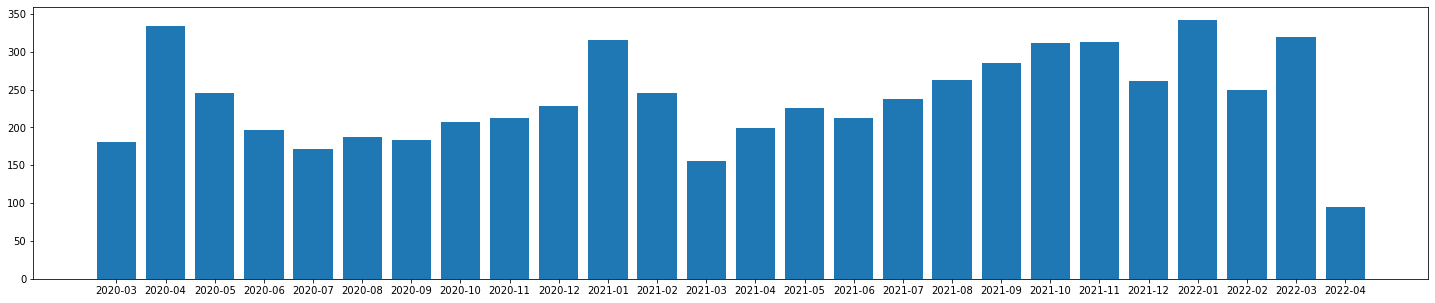

In [25]:
plt.figure(figsize=(25,5))
pl = plt.bar(list(dic.keys()),values_num)

In [26]:
d = { "x": df['Global covid-19 New Cases'], "y": df['posts positive rate']}
new_df = pd.DataFrame(d)
mod = smf.ols('y ~ x', data=new_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     6.231
Date:                Sun, 29 May 2022   Prob (F-statistic):             0.0198
Time:                        01:16:34   Log-Likelihood:                 47.736
No. Observations:                  26   AIC:                            -91.47
Df Residuals:                      24   BIC:                            -88.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5529      0.011     48.950      0.0

In [27]:
d = { "x": df['Global covid-19 New Cases'], "y": df['posts neutral rate']}
new_df = pd.DataFrame(d)
mod = smf.ols('y ~ x', data=new_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     11.79
Date:                Sun, 29 May 2022   Prob (F-statistic):            0.00217
Time:                        01:16:34   Log-Likelihood:                 46.252
No. Observations:                  26   AIC:                            -88.50
Df Residuals:                      24   BIC:                            -85.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3209      0.012     26.835      0.0

In [28]:
d = { "x": df['Global covid-19 New Cases'], "y": df['posts negative rate']}
new_df = pd.DataFrame(d)
mod = smf.ols('y ~ x', data=new_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.658
Date:                Sun, 29 May 2022   Prob (F-statistic):              0.116
Time:                        01:16:35   Log-Likelihood:                 57.059
No. Observations:                  26   AIC:                            -110.1
Df Residuals:                      24   BIC:                            -107.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1262      0.008     15.986      0.0

In [29]:
corr = pearsonr(df['Global covid-19 New Cases'],df['posts positive rate'])
print(corr)

(0.4539949765325788, 0.01982171342881464)


In [30]:
corr = pearsonr(df['Global covid-19 New Cases'],df['posts neutral rate'])
print(corr)

(-0.573945194353964, 0.002170561973394867)


In [31]:
corr = pearsonr(df['Global covid-19 New Cases'],df['posts negative rate'])
print(corr)

(0.31577068926878765, 0.11607869045800664)


In [32]:
corr = pearsonr(df['Global covid-19 New Cases'],df['Posts(num)'])
print(corr)

(0.41288272636661927, 0.03605369355729308)


In [33]:
corr = pearsonr(np.diff(df['Global covid-19 New Cases']),np.diff(df['Posts(num)']))
print(corr)

(0.5073691963188636, 0.009630509105315384)


In [34]:
corr = pearsonr(np.diff(df['Global covid-19 New Cases']),np.diff(df['posts positive rate']))
print(corr)

(0.14911854666691313, 0.4768276769128347)


In [35]:
corr = pearsonr(np.diff(df['Global covid-19 New Cases']),np.diff(df['posts neutral rate']))
print(corr)

(-0.09514311011515286, 0.6509885235913813)


In [36]:
corr = pearsonr(np.diff(df['Global covid-19 New Cases']),np.diff(df['posts negative rate']))
print(corr)

(-0.041258897609619295, 0.8447542234050858)


In [37]:
def permutation_test(dataframe, column_name, num_perm = 15000):
    permutation_statistics = []
    original_statistic = np.abs(np.corrcoef(dataframe[column_name],dataframe['Global covid-19 New Cases'])[1][0])
    for i in range(num_perm):
        shuffled_df = np.random.permutation(dataframe['Global covid-19 New Cases'])
        perm_statistic = np.corrcoef(dataframe[column_name], shuffled_df)[1][0]
        permutation_statistics.append(perm_statistic)
    permutation_statistics = np.array(permutation_statistics)
    p_val = (sum(np.abs(permutation_statistics) >= original_statistic))/(num_perm)
    return np.around(p_val,4)

In [38]:
permutation_test(df, 'Posts(num)', num_perm = 15000)

0.0347

In [39]:
permutation_test(df, 'posts positive rate', num_perm = 15000)

0.0121

In [40]:
permutation_test(df, 'posts neutral rate', num_perm = 15000)

0.0009

In [41]:
permutation_test(df, 'posts negative rate', num_perm = 15000)

0.1143

In [42]:
def permutation_test_diff(dataframe, column_name, num_perm = 15000):
    permutation_statistics = []
    original_statistic = np.abs(np.corrcoef(np.diff(dataframe[column_name]),np.diff(dataframe['Global covid-19 New Cases']))[1][0])
    for i in range(num_perm):
        shuffled_df = np.random.permutation(np.diff(dataframe['Global covid-19 New Cases']))
        perm_statistic = np.corrcoef(np.diff(dataframe[column_name]), shuffled_df)[1][0]
        permutation_statistics.append(perm_statistic)
    permutation_statistics = np.array(permutation_statistics)
    p_val = (sum(np.abs(permutation_statistics) >= original_statistic))/(num_perm)
    return np.around(p_val,4)

In [43]:
permutation_test_diff(df, 'Posts(num)', num_perm = 15000)

0.0232

In [44]:
permutation_test_diff(df, 'posts positive rate', num_perm = 15000)

0.4694

In [45]:
permutation_test_diff(df, 'posts neutral rate', num_perm = 15000)

0.6481

In [46]:
permutation_test_diff(df, 'posts negative rate', num_perm = 15000)

0.8508

Note: These data are saved manually in the table. The results of the p-value are slightly different every time re-run the code due to the randomization.

### Topic modeling for different years

In [47]:
workfromhome20 = get_contents('WorkFromHome20')

2137


In [48]:
workfromhome21 = get_contents('WorkFromHome21')

3016


In [49]:
workfromhome22 = get_contents('WorkFromHome22')

1007


**All the results of topic modeling are only presented in jupyter notebook.**   
**To visualize the results, you need to re-run the code. Once the notebook is closed, the visualization graph is hidden.**

### 2020

In [50]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    raw_texts = []
    for text in texts:
        raw_texts.append(text)
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        final = re.sub('https?:[^\s]+', '', final)
        texts_out.append(final)
    return texts_out,raw_texts


In [51]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [52]:
def make_bigrams(texts):
    return([bigram20[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram20[bigram20[doc]] for doc in texts])

In [53]:
stopwords = stopwords.words("english")

In [54]:
workfromhome2020 = []
for k,v in workfromhome20.items():
    workfromhome2020.append(v['text'])
    
lemmatized_texts20, raw_texts20 = lemmatization(workfromhome2020)
data_words20 = gen_words(lemmatized_texts20)

#BIGRAMS AND TRIGRAMS
bigram_phrases20 = gensim.models.Phrases(data_words20, min_count=5, threshold=30)
trigram_phrases20 = gensim.models.Phrases(bigram_phrases20[data_words20], threshold=30)

bigram20 = gensim.models.phrases.Phraser(bigram_phrases20)
trigram20 = gensim.models.phrases.Phraser(trigram_phrases20)

data_bigrams20 = make_bigrams(data_words20)
data_bigrams_trigrams20 = make_trigrams(data_bigrams20)


word_lst = ['get','just','go','so','do','take','make','give','vs','also','let','th','amp','etc','ve',"seem", "think","look","thing","else","already","turn","way","see","say","one","come","bit","actually","set","put","sure","lot","even","maybe","whole","ensure","co"]

new_data_bigrams_trigrams20 = []
for lst in data_bigrams_trigrams20:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams20.append(new_lst)
    
data_bigrams_trigrams20 = new_data_bigrams_trigrams20


id2word20 = corpora.Dictionary(data_bigrams_trigrams20)
texts20 = data_bigrams_trigrams20
corpus20 = [id2word20.doc2bow(text) for text in texts20]

lda_model20 = gensim.models.ldamodel.LdaModel(corpus=corpus20,
                                           id2word=id2word20,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis20 = gensim_models.prepare(lda_model20, corpus20, id2word20, mds="mmds", R=30)
vis20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.219651  0.331521       1        1  58.042852
4     -0.382494 -0.001837       2        1  17.822114
3      0.140911  0.324857       3        1  10.879892
2      0.317691 -0.078519       4        1   3.821331
6     -0.139329 -0.266024       5        1   2.971318
7      0.128016 -0.283615       6        1   2.730202
0      0.158638  0.048687       7        1   2.404931
5     -0.003783 -0.075069       8        1   1.327360, topic_info=            Term         Freq        Total Category  logprob  loglift
11          work  3163.000000  3163.000000  Default  30.0000  30.0000
23          home  1991.000000  1991.000000  Default  29.0000  29.0000
8           time   655.000000   655.000000  Default  28.0000  28.0000
24           job   488.000000   488.000000  Default  27.0000  27.0000
137         free   229.000000   229.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2503   otherwise     2.794341     3.605984   Topic8  -5.5923   4.0670
891   importance     2.770162     3.583676   Topic8  -5.6010   4.0645
357   reasonable     2.565870     3.376476   Topic8  -5.6776   4.0474
2414   interface     2.671761     3.518358   Topic8  -5.6371   4.0467
339        alert     2.629007     3.502921   Topic8  -5.6533   4.0350

[321 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
2542      8  0.818340              absolute
5680      5  0.966037               academy
451       2  0.988675               account
3141      8  0.877830                action
2015      7  0.946855                    ad
...     ...       ...                   ...
1336      6  0.913432                 worry
1710      2  0.982765                 worth
5217      5  0.921164  worth_cryptocurrency
323       7  0.946546                 wrong
52        1  0.997333                  year

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 7, 8, 1, 6])

### 2021

In [55]:
def make_bigrams(texts):
    return([bigram21[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram21[bigram21[doc]] for doc in texts])

In [56]:
workfromhome2021 = []
for k,v in workfromhome21.items():
    workfromhome2021.append(v['text'])
    
lemmatized_texts21, raw_texts21 = lemmatization(workfromhome2021)
data_words21 = gen_words(lemmatized_texts21)

#BIGRAMS AND TRIGRAMS
bigram_phrases21 = gensim.models.Phrases(data_words21, min_count=5, threshold=30)
trigram_phrases21 = gensim.models.Phrases(bigram_phrases21[data_words21], threshold=30)

bigram21 = gensim.models.phrases.Phraser(bigram_phrases21)
trigram21 = gensim.models.phrases.Phraser(trigram_phrases21)

data_bigrams21 = make_bigrams(data_words21)
data_bigrams_trigrams21 = make_trigrams(data_bigrams21)

new_data_bigrams_trigrams21 = []
for lst in data_bigrams_trigrams21:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams21.append(new_lst)
    
data_bigrams_trigrams21 = new_data_bigrams_trigrams21


id2word21 = corpora.Dictionary(data_bigrams_trigrams21)
texts21 = data_bigrams_trigrams21
corpus21 = [id2word21.doc2bow(text) for text in texts21]

lda_model21 = gensim.models.ldamodel.LdaModel(corpus=corpus21,
                                           id2word=id2word21,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis21 = gensim_models.prepare(lda_model21, corpus21, id2word21, mds="mmds", R=30)
vis21

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.233007  0.337798       1        1  40.791260
0      0.070392  0.401382       2        1  25.594578
1      0.382504 -0.167026       3        1  12.750330
5     -0.357186 -0.019485       4        1   5.585408
2      0.309705  0.141889       5        1   5.227356
4     -0.019604 -0.066458       6        1   4.031030
6     -0.225185 -0.309328       7        1   3.512283
7      0.072381 -0.318772       8        1   2.507755, topic_info=          Term         Freq        Total Category  logprob  loglift
64         job  1849.000000  1849.000000  Default  30.0000  30.0000
15        work  4075.000000  4075.000000  Default  29.0000  29.0000
122       time   662.000000   662.000000  Default  28.0000  28.0000
6         home  2452.000000  2452.000000  Default  27.0000  27.0000
351       free   327.000000   327.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1841      size    10.719993    11.514101   Topic8  -5.2996   3.6143
1201     adult    10.428695    11.222831   Topic8  -5.3272   3.6124
1596    bother    10.023533    10.818201   Topic8  -5.3668   3.6095
1127  directly     9.987244    10.783204   Topic8  -5.3704   3.6091
327        sit    42.180319    86.661999   Topic8  -3.9298   2.9657

[329 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
684       1  0.992409       able
545       6  0.985966     access
686       3  0.997423    account
1067      5  0.979862   activity
202       5  0.987467         ad
...     ...       ...        ...
2047      3  0.989560  workforce
1017      6  0.988460  workspace
1053      6  0.989391      world
948       7  0.971535      worth
266       2  0.997412       year

[349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 6, 3, 5, 7, 8])

### 2022

In [57]:
def make_bigrams(texts):
    return([bigram22[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram22[bigram22[doc]] for doc in texts])

In [58]:
workfromhome2022 = []
for k,v in workfromhome22.items():
    workfromhome2022.append(v['text'])
    
lemmatized_texts22, raw_texts22 = lemmatization(workfromhome2022)
data_words22 = gen_words(lemmatized_texts22)

#BIGRAMS AND TRIGRAMS
bigram_phrases22 = gensim.models.Phrases(data_words22, min_count=5, threshold=30)
trigram_phrases22 = gensim.models.Phrases(bigram_phrases22[data_words22], threshold=30)

bigram22 = gensim.models.phrases.Phraser(bigram_phrases22)
trigram22 = gensim.models.phrases.Phraser(trigram_phrases22)

data_bigrams22 = make_bigrams(data_words22)
data_bigrams_trigrams22 = make_trigrams(data_bigrams22)

new_data_bigrams_trigrams22 = []
for lst in data_bigrams_trigrams22:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams22.append(new_lst)
    
data_bigrams_trigrams22 = new_data_bigrams_trigrams22


id2word22 = corpora.Dictionary(data_bigrams_trigrams22)
texts22 = data_bigrams_trigrams22
corpus22 = [id2word22.doc2bow(text) for text in texts22]

lda_model22 = gensim.models.ldamodel.LdaModel(corpus=corpus22,
                                           id2word=id2word22,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis22 = gensim_models.prepare(lda_model22, corpus22, id2word22, mds="mmds", R=30)
vis22

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.205841  0.311712       1        1  42.408797
3     -0.369833  0.043646       2        1  22.173140
7      0.118732  0.299702       3        1  16.499381
6      0.331769  0.021202       4        1   6.120247
2     -0.148966 -0.263321       5        1   4.682696
0      0.154460 -0.287877       6        1   4.154354
5      0.112002 -0.030387       7        1   2.365378
1      0.007678 -0.094677       8        1   1.596007, topic_info=                   Term         Freq        Total Category  logprob  loglift
32                  job   738.000000   738.000000  Default  30.0000  30.0000
45                  wfh   377.000000   377.000000  Default  29.0000  29.0000
9                  work  1421.000000  1421.000000  Default  28.0000  28.0000
994               chair   101.000000   101.000000  Default  27.0000  27.0000
4                  home   680.000000   680.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
1283             wallet     1.671259     2.710109   Topic8  -5.8074   3.6543
2864  virtual_assistant     1.975893     4.664960   Topic8  -5.6399   3.2786
305                plan     2.317763    18.549679   Topic8  -5.4803   2.0578
0                  easy     2.581584    40.854107   Topic8  -5.3725   1.3761
969                free     2.224779    35.685109   Topic8  -5.5213   1.3626

[361 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
65        3  0.946827     account
285       8  0.760113  accounting
2460      7  0.811389          ad
600       1  0.482673      advice
600       2  0.509488      advice
...     ...       ...         ...
403       2  0.979487       wrong
172       1  0.104136        year
172       2  0.794724        year
172       3  0.054809        year
172       5  0.043847        year

[430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 7, 3, 1, 6, 2])

### Topic modeling for four different periods (where post positive rate is high)

#### first period

In [59]:
begin_text

['Researchers are interested in those newly working from home and how your employers have handled this pandemic period. The survey takes like 5-7 minutes. This research could help employers better handle the WFH transition. ',
 'How can you work from home effectively ',
 'TraffixZ Review⚠️Demo🤑 $2,991 Bonus🤑 Traffix Z Review ⚠️ ',
 'What remote viewer do you use? I’m curious what remote viewers everyone is using.  Is it free?  Does it let you remotely change display settings?   What do you like and dislike?',
 "Advice from someone who's been working from home for 3 years [https://youtu.be/vfKA45aIPp4](https://youtu.be/vfKA45aIPp4)\n\nHey everyone! I know a lot of people have just started working from home for the first time, and are looking for advice! I've been doing this for a while and have tried to put the most important things I've learned into a video. I hope it helps some folks!\n\nIf you don't feel like watching a video, here's a quick summary of the main points:\n\n* Figure ou

In [60]:
lemmatized_texts, raw_texts = lemmatization(begin_text)
data_words = gen_words(lemmatized_texts)

#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=30)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)
data_bigrams_trigrams = new_data_bigrams_trigrams

# Method 2
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.1
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [61]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [62]:
# first period: 6 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.007446  0.033653       1        1  28.075992
3      0.217191  0.030124       2        1  19.237093
4     -0.164589  0.052589       3        1  18.421329
2      0.082373 -0.139786       4        1  18.357936
1      0.028935  0.211257       5        1   8.745488
5     -0.156464 -0.187838       6        1   7.162162, topic_info=          Term       Freq      Total Category  logprob  loglift
4         home  36.000000  36.000000  Default  30.0000  30.0000
14         wfh  22.000000  22.000000  Default  29.0000  29.0000
24      remote  31.000000  31.000000  Default  28.0000  28.0000
81        know  15.000000  15.000000  Default  27.0000  27.0000
334       plan  13.000000  13.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
17      review   0.306528   0.953561   Topic6  -6.1799   1.5015
190     course   0.306398   0.953823   Topic6  -6.1804   1.5008
321       move   2.355916   8.930545   Topic6  -4.1406   1.3038
197  education   0.682419   8.114570   Topic6  -5.3796   0.1606
135       stay   0.423051   5.516508   Topic6  -5.8578   0.0684

[263 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1094      4  0.717653    academy
271       1  0.923149     access
31        1  0.897630     advice
1012      3  0.688294     affect
1124      2  0.841247      ahead
...     ...       ...        ...
372       1  0.730220     worker
157       6  0.655609  workspace
161       1  0.267558       year
161       3  0.089186       year
161       4  0.624302       year

[280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2, 6])

#### second period

In [63]:
lemmatized_texts, raw_texts = lemmatization(first_wave_text)
data_words = gen_words(lemmatized_texts)

#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=30)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)
data_bigrams_trigrams = new_data_bigrams_trigrams

from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.1
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [64]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [65]:
# second period: 6 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.145961 -0.261548       1        1  26.012376
5     -0.143425  0.244734       2        1  17.949743
1      0.128139 -0.217393       3        1  17.246869
4      0.118612  0.214984       4        1  14.058411
2      0.284482  0.000336       5        1  13.757144
3     -0.241847  0.018886       6        1  10.975457, topic_info=          Term        Freq       Total Category  logprob  loglift
37        work  126.000000  126.000000  Default  30.0000  30.0000
110        job  236.000000  236.000000  Default  29.0000  29.0000
24      remote   80.000000   80.000000  Default  28.0000  28.0000
12        home  149.000000  149.000000  Default  27.0000  27.0000
175       free   73.000000   73.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
8     employee   14.780319   28.920715   Topic6  -4.5967   1.5382
120      month   10.604173   20.752910   Topic6  -4.9287   1.5381
691     minute    8.117786   18.598690   Topic6  -5.1959   1.3805
123        new    7.643048   19.382021   Topic6  -5.2562   1.2790
1078     leave    7.465132   17.375762   Topic6  -5.2797   1.3647

[290 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
58        1  0.367234        able
58        2  0.612056        able
1         1  0.965118     account
997       6  0.940527     adapter
257       4  0.948737  adjustable
...     ...       ...         ...
885       6  0.837808      worker
170       3  0.973935       world
857       1  0.979777       worth
778       5  0.959978       write
388       2  0.954282        year

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 5, 3, 4])

#### third period

In [66]:
lemmatized_texts, raw_texts = lemmatization(second_wave_text)
data_words = gen_words(lemmatized_texts)

#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=30)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)
data_bigrams_trigrams = new_data_bigrams_trigrams

from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.1
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [67]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [68]:
# third period: 6 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.138582  0.224353       1        1  24.444649
5      0.248971  0.001883       2        1  16.640164
2     -0.238036 -0.001316       3        1  16.259146
4      0.133063 -0.213776       4        1  16.070826
3      0.117612  0.206167       5        1  14.080306
0     -0.123028 -0.217310       6        1  12.504910, topic_info=       Term       Freq      Total Category  logprob  loglift
3      work  69.000000  69.000000  Default  30.0000  30.0000
347    hour  45.000000  45.000000  Default  29.0000  29.0000
23    start  37.000000  37.000000  Default  28.0000  28.0000
81      job  83.000000  83.000000  Default  27.0000  27.0000
297    team  30.000000  30.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
177  people   8.987036  29.251652   Topic6  -4.7501   0.8989
2      week   6.634809  15.476629   Topic6  -5.0536   1.2320
26      use  10.807988  48.511631   Topic6  -4.5656   0.5775
81      job  10.873117  83.615755   Topic6  -4.5596   0.0391
77     free   7.080517  29.824476   Topic6  -4.9886   0.6411

[311 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
398       3  0.981242     advice
919       2  0.969882        ago
2409      2  0.929620         ai
1735      3  0.904779      alone
1385      4  0.819032  anonymous
...     ...       ...        ...
971       5  0.738920  workspace
1045      3  0.921249      write
304       1  0.477259       year
304       2  0.053029       year
304       3  0.424230       year

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 5, 4, 1])

#### fourth period

In [69]:
lemmatized_texts, raw_texts = lemmatization(fourth_wave_text)
data_words = gen_words(lemmatized_texts)

#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=30)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)
data_bigrams_trigrams = new_data_bigrams_trigrams

from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.1
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [70]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [71]:
# fourth period: 6 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.366315  0.073137       1        1  19.971863
7      0.215219  0.286444       2        1  16.994454
5      0.348687 -0.103870       3        1  15.957194
0      0.140047  0.027839       4        1  11.620794
2     -0.203610 -0.269310       5        1  11.520806
3     -0.104638  0.298421       6        1   9.248639
1      0.079354 -0.293208       7        1   9.109554
4     -0.108745 -0.019453       8        1   5.576694, topic_info=       Term        Freq       Total Category  logprob  loglift
15      job  293.000000  293.000000  Default  30.0000  30.0000
4      home  114.000000  114.000000  Default  29.0000  29.0000
39   remote  126.000000  126.000000  Default  28.0000  28.0000
28      wfh  102.000000  102.000000  Default  27.0000  27.0000
31      day   75.000000   75.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
501    hard   10.947521   24.839995   Topic8  -4.5995   2.0672
938  course    9.399261   22.652143   Topic8  -4.7520   2.0070
470   month    7.436770   28.068663   Topic8  -4.9862   1.5584
31      day    9.030827   75.675606   Topic8  -4.7920   0.7608
136    hour    5.835357   71.462384   Topic8  -5.2287   0.3813

[350 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
48        1  0.764500      able
48        2  0.205827      able
553       5  0.963488    accept
100       2  0.954158   account
532       8  0.923921  activity
...     ...       ...       ...
1305      8  0.860082     worry
552       4  0.925707     worth
1331      8  0.947006     write
517       6  0.973826   writing
191       5  0.975617      year

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 6, 1, 3, 4, 2, 5])